# Changer :
Définition de saut,
Ruines 1-1 numba

In [2]:
import numpy as np
import math
import matplotlib.pyplot

## Q1

Dans cette première modélisation simplifiée, on considère donc que le prix $P_t$ est un processus de Poisson de paramètres $\lambda, \nu$ où $\nu$ est la loi des incréments $J_n$. 

Pour un temps d'attente moyen entre deux sauts de $300s$, on prend $\lambda = \dfrac{1}{300}$


### Q1 -1 Probabilité de ruine


In [3]:
# On identifie le processus par le processus de Poisson composé, qui finit à un temps fixé T
# On crée des fonctions pour modéliser le processus.

#### On définit nu, la loi des incréments
# Ancien : plus lent
saut_1_ancien = lambda x: np.random.choice([-1, 1], size=x, replace=True, p=[0.5, 0.5]) #correspond à m=1
saut_2_ancien = lambda x: np.random.choice([-3, -2, -1, 1, 2, 3], size=x, replace=True, p=0.5*np.array([1/6, 1/3, 1/2, 1/2, 1/3, 1/6])) #correspond à m=3

# Nouveau : beaucoup plus vite
value_1 = np.array([-1, 1])
value_2 = np.array([-3, -2, -2, -1, -1, -1, 1, 1, 1, 2, 2, 3])
saut_1 = lambda x : value_1[np.random.randint(low=2, size=x)]
saut_2 = lambda x : value_2[np.random.randint(low=12, size=x)]

# Les paramètres
P0 = 35
T = 4*60*60
lamb = 1/300

## Monte carlo naif

In [5]:
## Monte-Carlo Naif avec numba

from numba import jit

@jit(nopython=True)
def inf_echantillon(N, J, P0): # Function is compiled to machine code when called the first time
  ruines = 0
  for i in range(len(N) - 1):
    somme = P0
    ruine = 0
    for j in range(N[i], N[i + 1]):
      somme += J[j]
      if somme < 0:
        ruine = 1
        break
    ruines += ruine
  return ruines

def trajectoire(P0, T, lamb, saut, size):
  if size > int(1e7):
    sizes = size
    size = int(1e7)
    proba = 0
    for i in range(sizes // size):
      N = np.random.poisson(lam=lamb * T, size=size + 1)
      N[0] = 0
      N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                        # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
      J = saut(N[-1] + 1)
      res = inf_echantillon(N, J, P0)
      proba += res / size / (sizes // size)
    return proba
  else:
    N = np.random.poisson(lam=lamb * T, size=size + 1)
    N[0] = 0
    N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                      # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
    J = saut(N[-1] + 1)
    res = inf_echantillon(N, J, P0)
    proba = res / size
    return proba

In [9]:
%%timeit
M = int(1e6)
p_r = trajectoire(P0, T, lamb, saut_2, size=M)
R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance
print(p_r)
print(R_IC)

#print(trajectoire(P0, T, lamb, saut_1, size=int(1e7)))

#m=1
#0.00279 pour P0 = 20 M = 10^5 (total time 161 ms)
#5e-07 pour P0=35 et M=10^7 total time : 16.1 s
#quand on fait la moyenne sur 10 essais à M=10^7, on trouve proba_emp = 2.009975 e-7 et sigma_emp = 3.6 e-7 (tout ça pour m=1)

#m=3
#proba_emp=0.0043245, sigma_emp = 7.1273066441679e-05

0.004345
0.00012891557833543624
0.004362
0.00012916642329866378
0.0044
0.0001297253507376257
0.004318
0.00012851615342688091
0.004372
0.0001293137478477273
0.004281
0.0001279667329684649
0.004224
0.00012711560052439827
0.004307
0.00012835306215062267
526 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%time
M = int(1e7)
p_r = trajectoire(P0, T, lamb, saut_1, size=M)
R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance
print(p_r)
print(R_IC)

6e-07
4.800998455554844e-07
CPU times: user 3.15 s, sys: 1.11 s, total: 4.26 s
Wall time: 4.27 s


In [28]:
%%time
M = int(1e9)
p_r = trajectoire(P0, T, lamb, saut_1, size=M)
R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance
print(p_r)
print(R_IC)

3.6099999999999996e-07
3.7239993278179387e-08
CPU times: user 5min 16s, sys: 1min 48s, total: 7min 5s
Wall time: 7min 5s


In [29]:
%%time
M = int(1e9)
p_r = trajectoire(P0, T, lamb, saut_2, size=M)
R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance
print(p_r)
print(R_IC)

0.004332091999999999
4.070634992105756e-06
CPU times: user 8min 42s, sys: 1min 49s, total: 10min 32s
Wall time: 10min 32s


## Echantillionage d'importance

In [9]:
## Echantillionage d'importance

from numba import jit

@jit(nopython=True)# Function is compiled to machine code when called the first time
def inf_echantillon_importance(N, J, P0, lambT, s, f_dic): 
  ruines = 0.
  ruines_carre = 0.
  for i in range(len(N) - 1):
    somme = P0
    ruine = 0.
    ruine_carre = 0.
    for j in range(N[i], N[i + 1]):
      somme += J[j]
      if somme < 0:
        # Calculer L_T
        X_T_f = np.sum(f_dic[ J[N[i]:N[i+1]] ])
        L_T = np.exp(X_T_f - (s - 1) * lambT)
        ruine = 1 / L_T
        ruine_carre = 1 / L_T / L_T
        break
    ruines += ruine
    ruines_carre += ruine_carre
  return ruines, ruines_carre

def trajectoire_importance(P0, T, lamb, m, size, f):
  if m == 1:
    value = np.array([-1, 1])
    p = np.array([1/2, 1/2])
  else:
    value = np.array([-3, -2, -1, 1, 2, 3])
    p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
    
  # Nouvelle loi
  s = np.sum(np.exp(f[value]) * p)
  new_lamb = lamb * s
  new_p = np.exp(f[value]) * p / s

  N = np.random.poisson(lam=new_lamb * T, size=size + 1)
  N[0] = 0
  N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                    # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
  
  J = np.random.choice(value, size=N[-1] + 1, p=new_p)
  ruines, ruines_carre = inf_echantillon_importance(N, J, P0, lamb * T, s, f)
  proba = ruines / size
  R_IC = 1.96 * np.sqrt(ruines_carre / size - proba * proba) / np.sqrt(size)
  return proba, R_IC

def meilleur_coeff(m, func, l_ = -100, r_ = 100):
    
    # f_dic : un map de p à f[p]. La forme étant [f[0], f[1], f[2], f[3], f[-3], f[-2], f[-1]] ou [f[0], f[1], f[-1]]
    if m == 3:
      value = np.array([-3, -2, -1, 1, 2, 3])
      p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
      f_dic = np.array([0, 1, 2, 3, -3, -2, -1])
    else:
      value = np.array([-1, 1])
      p = np.array([0.5, 0.5])
      f_dic = np.array([0, 1, -1])

    l = l_
    f = func(f_dic, l)
    print("l =", l, "\tEspérance =", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    r = r_
    f = func(f_dic, r)
    print("r =", r, "\tEspérance =", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    r_sign = np.sign(P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    while r - l > 1e-6:
      c = (r + l) / 2
      f = func(f_dic, c)
      if np.sign(P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p)) == r_sign:
        r = c
      else:
        l = c
    print("c =", c, "Espérance =", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))

    p_r, R_IC = trajectoire_importance(P0, T, lamb, m, M, f)

    print("Probabilité :", p_r)
    print("Rayon de l'intervalle de confiance :", R_IC)
    print("Intervalle de confiance : [{}, {}]".format(p_r - R_IC, p_r + R_IC))

In [10]:
%%time
# Les paramètres
P0 = 35
T = 4*60*60
lamb = 1/300
m = 1
M = int(1e7)

################### f(x) = c *  x #######################
meilleur_coeff(m, lambda x, c: x * c)

l = -100 	Espérance = -1.3440585709080678e+43
r = 100 	Espérance = 1.3440585709080678e+43
c = -0.6763972342014313 Espérance = -1.3405811405409196e-07
Probabilité : 3.523738211561328e-07
Rayon de l'intervalle de confiance : 9.902728636760782e-10
Intervalle de confiance : [3.5138354829245673e-07, 3.533640940198089e-07]
CPU times: user 10.4 s, sys: 2.76 s, total: 13.2 s
Wall time: 13.2 s


In [11]:
%%time
m = 3
################### f(x) = c * x  #######################
meilleur_coeff(m, lambda x, c: c * x, -10, 10)

l = -10 	Espérance = -2671780372618.806
r = 10 	Espérance = 2671780372620.2646
c = -0.20969092845916748 Espérance = -9.686956652377177e-07
Probabilité : 0.004330342602748714
Rayon de l'intervalle de confiance : 7.116356671655372e-06
Intervalle de confiance : [0.004323226246077058, 0.004337458959420369]
CPU times: user 12 s, sys: 2.38 s, total: 14.4 s
Wall time: 14.4 s


In [12]:
%%time
################### f(x) = c * x ** 3 #######################
meilleur_coeff(m, lambda x, c: c * x ** 3, -10, 10)

l = -10 	Espérance = -4.544123462847749e+116
r = 10 	Espérance = 4.544123462847749e+116
c = -0.03409087657928467 Espérance = 1.4896594524471674e-05
Probabilité : 0.004348664410402502
Rayon de l'intervalle de confiance : 2.029487881075748e-05
Intervalle de confiance : [0.004328369531591745, 0.00436895928921326]
CPU times: user 12.2 s, sys: 2.5 s, total: 14.7 s
Wall time: 14.7 s


## Splitting


In [3]:
## Splitting et MCMC - Méthode 3
def NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut):

    """
    Fonction qui renvoie une estimation des niveaux
    de splitting a_1, a_2, ..., a_k tels que P(Phi_T <= a_k | Phi_T <= a_{k-1}) = 0.1 = seuil
    (où Phi_T : inf de P_t pour t dans [0;T])
    Ces niveaux sont des quantiles d'une loi conditionnelle.
    On utilise l'inversion de la fonction de repartition empirique de 
    cette loi afin d'estimer un quantile par
    le quantile empirique.
    On a a = a_k < a_{k-1} < ... < a_0= + infini (dans notre problème, a = 0)
    La fonction renvoie quantiles = [a_1, ..., a_k]
    """
    ## Estimation du premier niveau a_1: c'est le 
    ## quantile d'une loi non conditionnelle.
    ## On l'estime ici par la methode ergodique

    liste_Phi = np.zeros(M1)

    liste_sauts = liste_sts(lamb,T,saut)
    liste_sauts_min = None
    Phi_min = 100000
    
    for l in range(M1):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        nc = coloriage.shape[1]
        nt = liste_sauts_tilde.shape[1]
        new_liste_sauts = np.zeros((2, nc + nt))
        new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
        #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        #new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        liste_Phi[l] = Phi(liste_sauts,P0)
        if liste_Phi[l] < Phi_min:
            liste_sauts_min = np.copy(liste_sauts)
            Phi_min = liste_Phi[l]

    liste_Phi.sort()
    
    quantiles = np.array([liste_Phi[int(np.ceil(seuil*M1))-1]])    

    while quantiles[-1] > a:
        #print("Inside while", quantiles[-1], Phi(liste_sauts_min, P0))
        if quantiles[-1] <= a + 1:
            quantiles = np.append(quantiles, a)
            break
        
        liste_Phi = np.zeros(M1)
        
        liste_sauts = np.copy(liste_sauts_min)
        phi_actual = Phi(liste_sauts, P0)
        Phi_min = 100000

        ## Simulation du processus AR(1) conditionnel
    
        for l in range(M1):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]
            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
            
            nc = coloriage.shape[1]
            nt = liste_sauts_tilde.shape[1]
            new_liste_sauts = np.zeros((2, nc + nt))
            new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
            #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            #new_liste_sauts = tri_temps(new_liste_sauts)
            
            phi_local = Phi(new_liste_sauts,P0)
            
            if phi_local<quantiles[-1]:
                liste_sauts = new_liste_sauts
                phi_actual = phi_local

            liste_Phi[l] = phi_actual
            if liste_Phi[l] < Phi_min:
                liste_sauts_min = np.copy(liste_sauts)
                Phi_min = liste_Phi[l]

        liste_Phi.sort()
        quantile = liste_Phi[int(np.ceil(seuil*M1)) - 1]
        if quantile >= quantiles[-1]:
            quantiles = np.append(quantiles, quantiles[-1] - 1)
        else:
            quantiles = np.append(quantiles, quantile)


    ## On selectionne les niveaux a_{k-1},..., a_1 strictement au dessus de a
    quantiles = quantiles[:-1]
    ## On rajoute a
    quantiles = np.append(quantiles,a)

    return quantiles


from numba import jit

@jit(nopython=True)
def Phi(liste_sauts, P0): # Function is compiled to machine code when called the first time
    prix_min = P0
    if len(liste_sauts[0]) == 0:
        return P0
    for i in liste_sauts[1, :]:
        P0 += i
        if P0 < prix_min:
            prix_min = P0
    return prix_min

'''def Phi(liste_sauts,P0):#fonction qui renvoie l'inf des valeurs de X aux instants de saut
    #ie l'inf de P0+cumsum(incréments) 
    if len(liste_sauts[0]) == 0:
        return P0
    liste_prix = P0+np.cumsum(liste_sauts[1,:])
    prix_min = np.min(liste_prix)
    return prix_min'''

def liste_sts(lbda, T, saut):
    N = np.random.poisson(lbda*T)
    liste_sauts = np.zeros((2, N))
    liste_sauts[0, :] = np.sort(np.random.uniform(low=0, high=T, size=N))
    liste_sauts[1, :] = saut(N)
    #renvoie un array de N colonnes et 2 lignes: 1ere ligne pour les temps des sauts (T_n), deuxième ligne pour leurs amplitudes (J_n)
    return liste_sauts
    #liste_temps_sauts = np.random.uniform(low = 0, high = T, size = N)
    #liste_temps_sauts_triee = [np.sort(liste_temps_sauts)]
    #liste_increments = [saut(N)]
    #return np.concatenate((liste_temps_sauts_triee,liste_increments),axis=0)

@jit(nopython=True)
def new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt):
    i = 0
    j = 0
    k = 0
    # Merge two listes triées
    while i < nc:
        T1 = coloriage[0, i]
        while j < nt and liste_sauts_tilde[0, j] < T1:
            new_liste_sauts[:, k] = liste_sauts_tilde[:, j]
            j += 1
            k += 1
        new_liste_sauts[:, k] = coloriage[:, i]
        i += 1
        k += 1
    while j < nt:
        new_liste_sauts[:, k] = liste_sauts_tilde[:, j]
        j += 1
        k += 1
    return new_liste_sauts

def tri_temps(new_liste_sauts):
    ordre = [new_liste_sauts[0,:].argsort()]
    liste_sauts_triee = np.take_along_axis(new_liste_sauts, np.concatenate((ordre,ordre),axis=0), axis=1) 
    return liste_sauts_triee


def MCMC(M2,p,lamb,liste_a,P0,saut):

    liste_pi = np.zeros(len(liste_a)) #estimateurs des probabilités conditionnelles

    liste_indicatrices = np.zeros(M2,dtype=bool) 
    """
    le k-ieme élém. de liste_indicatrices vaut True si le prix devient négatif avant l'instant T lors du k-ieme essai; False sinon
    """

    #Loi non conditionnelle
    
    liste_sauts = liste_sts(lamb,T,saut)
    liste_sauts_min = None
    Found = False

    for l in range(M2):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]
        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        
        nc = coloriage.shape[1]
        nt = liste_sauts_tilde.shape[1]
        new_liste_sauts = np.zeros((2, nc + nt))
        new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
        #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        #new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        if Phi(liste_sauts, P0) < liste_a[0]:
            liste_indicatrices[l] = True
            if not Found:
                liste_sauts_min = np.copy(liste_sauts)
                Found = True

    liste_pi[0] = np.mean(liste_indicatrices)
    
    for k in range(1,len(liste_a)):
        liste_indicatrices = np.zeros(M2,dtype=bool)  

        #Initialisation 
        liste_sauts = np.copy(liste_sauts_min)
        phi_actual = Phi(liste_sauts, P0)
        
        Found = False

        for l in range(M2):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)

            nc = coloriage.shape[1]
            nt = liste_sauts_tilde.shape[1]
            new_liste_sauts = np.zeros((2, nc + nt))
            new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
            #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            #new_liste_sauts = tri_temps(new_liste_sauts)

            phi_local = Phi(new_liste_sauts, P0)
            
            if phi_local < liste_a[k-1]:
                liste_sauts = new_liste_sauts
                phi_actual = phi_local

            if phi_actual < liste_a[k]:
                liste_indicatrices[l] = True
                if not Found:
                    liste_sauts_min = np.copy(liste_sauts)

        liste_pi[k] = np.mean(liste_indicatrices)
    
    proba_prix_negatif = np.prod(liste_pi)
    return proba_prix_negatif

In [4]:
P0 = 35 
T = 4*60*60 #conversion en secondes
lamb =  1/300 
M1 = int(1e3) 
M2 = 14400
n = 10
a=0
#Choix des paramètres pour les niveaux de splitting et la simulation par chaîne de Markov
seuil = 0.03
p=0.5

def Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut):
    liste_a = NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut)
    print(liste_a)
    probas = np.zeros(n)
    from tqdm.notebook import tqdm
    for i in tqdm(range(n)):
        probas[i] = MCMC(M2 // len(liste_a), p, lamb, liste_a, P0, saut)
    #proba_emp = np.mean(probas)
    #sigma_emp = np.std(probas) / np.sqrt(n) #écart-type empirique de la moyenne des n estimateurs
    #print(proba_emp)
    #print(sigma_emp)
    #print("Estimation de la probabilité de ruine pour m=1 par méthode de Splitting/MCMC: {:09.8f}+/-{:09.8f}".format(proba_emp,sigma_emp))
    return probas

In [5]:
%%time
Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut_1)
#Réponse pour m=1 ie k=0 et P0=35 : proba = 3.333674930684664e-07, variance = 5 10^-8
#m=3 et P0=35: proba = 0.004309577501008395, variance = 0.00010259619121779947
#m=1 liste_a = [24. 17. 12.  7.  3.  0.] seuil =0.1 M=10^4 n=10 proba_emp=4.619226215866903e-07 sigma_emp= 9.561801048257746e-08
#m=1 liste_a= [20. 12.  5.  0.] seuil = 0.03 P0=35 M=10^4 n=10 proba_emp = 3.6218700696e-07 sigma_emp = 7.599237232859178e-08 
#same avec M=10^5 proba_emp = 3.4354401671979703e-07. sigma_emp= 1.3033966706232877e-08 LE MEILLEUR QU ON AIT

[22. 14.  6.  1.  0.]



CPU times: user 6.88 s, sys: 7.9 ms, total: 6.89 s
Wall time: 6.89 s


array([2.58988314e-08, 5.13983271e-07, 1.84367169e-07, 4.19008172e-07,
       3.08768348e-07, 4.62203260e-07, 4.76199581e-07, 1.25939316e-06,
       1.08997935e-07, 5.25971401e-07])

In [38]:
import matplotlib.pyplot as plt
def xtick(seuils, ps):
    lis = []
    for i in range(len(seuils)):
        for j in range(len(ps)):
            if i == 0 and j == 0:
                lis.append("Seuil \n p")
            elif j == len(ps) // 2:
                lis.append(str(seuils[i]) + "\n" + str(ps[j]))
            else:
                lis.append(" \n" + str(ps[j]))
    return lis

def remove_pair_name(i, ps):
    return str(ps[i]) * ((i - 1)%2) + "" * (i % 2)

def analyse(filename, seuils, ps):
    ls = len(seuils)
    lp = len(ps)
    x_name = xtick(seuils, ps)
    proba = np.load(filename)
    
    # Plot écart-type
    plot_data = (proba.std(axis=2) / proba.mean(axis=2))
    plot_data = np.nan_to_num(plot_data, 0)
    plot_data[plot_data == 0] = plot_data.max()
    plt.imshow(plot_data, cmap=plt.cm.Blues)
    plt.xticks([i for i in range(lp)], [remove_pair_name(i, ps) for i in range(len(ps))])
    plt.xlabel("p")
    plt.yticks([i for i in range(ls)], seuils)
    plt.ylabel("Seuils")
    plt.colorbar()
    plt.title("Heatmap\nEcart-type/Estimation")

    # Save fig
    outputname = filename.replace("probas", "var-heatmap").replace("npy", "png")
    plt.savefig(outputname)
    plt.show()
    
    
    # Boxplot
    plt.figure(figsize=(ls * lp * 0.4, 5))
    plt.boxplot([proba[i][j] for i in range(ls) for j in range(lp)])
    plt.xticks([i+1 for i in range(ls * lp)], x_name)
    outputname = filename.replace("probas", "result").replace("npy", "png")
    plt.savefig(outputname)
    plt.show()

In [34]:
def Heatmap(outputname, seuils, ps, n, saut):
    proba = np.zeros((len(seuils), len(ps), n))
    for i in range(len(seuils)):
      seuil = seuils[i]
      for j in range(len(ps)):
        p = ps[j]
        print("Processing with seuil = {}, p = {}".format(seuil, p))
        proba[i][j] = Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut)
    np.save(outputname, proba)

### m = 1

/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


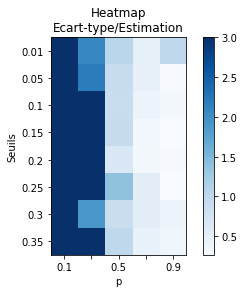

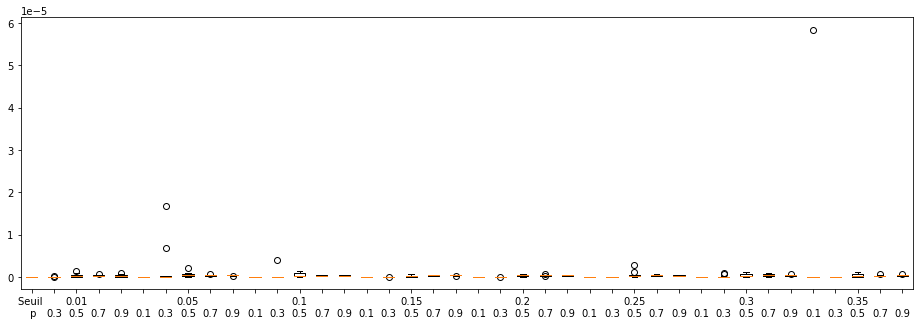

CPU times: user 746 ms, sys: 4.99 ms, total: 751 ms
Wall time: 750 ms


In [39]:
%%time
seuils = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
ps = [0.1, 0.3, 0.5, 0.7, 0.9]
#Heatmap("probas1", seuils, ps, n, saut_1)
analyse("probas1.npy", seuils, ps)

/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


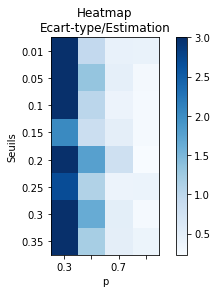

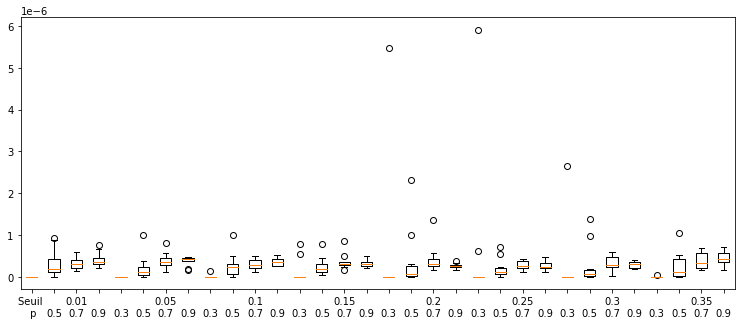

CPU times: user 582 ms, sys: 2.97 ms, total: 585 ms
Wall time: 583 ms


In [40]:
%%time
seuils = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
ps = [0.3, 0.5, 0.7, 0.9]
#Heatmap("probas2", seuils, ps, n, saut_1)
analyse("probas2.npy", seuils, ps)

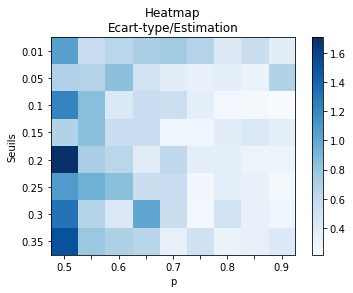

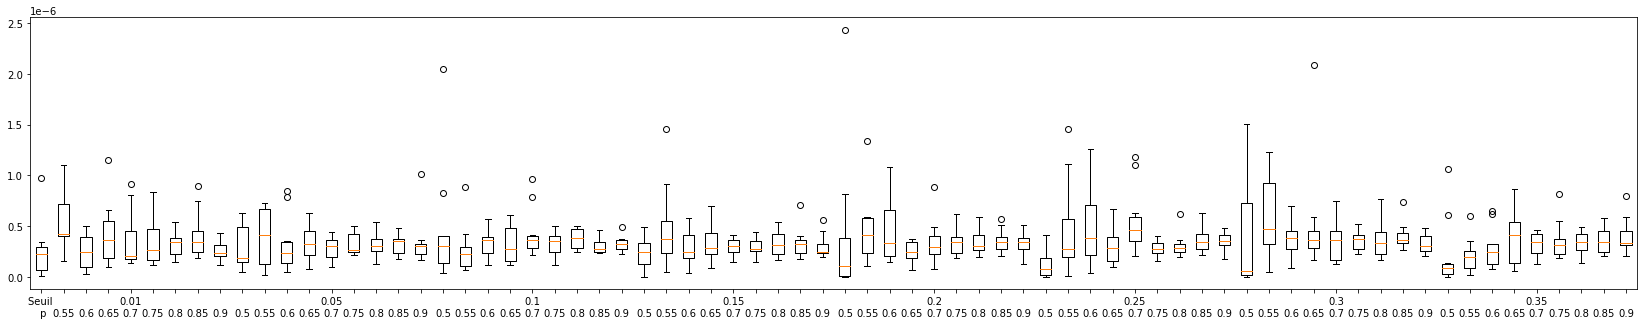

CPU times: user 1.32 s, sys: 24 ms, total: 1.35 s
Wall time: 1.34 s


In [41]:
%%time
seuils = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
ps = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
#Heatmap("probas3", seuils, ps, n, saut_1)
analyse("probas3.npy", seuils, ps)

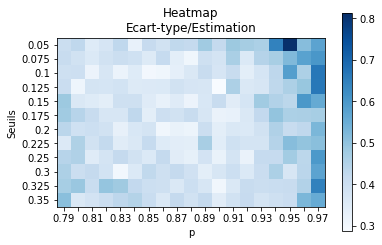

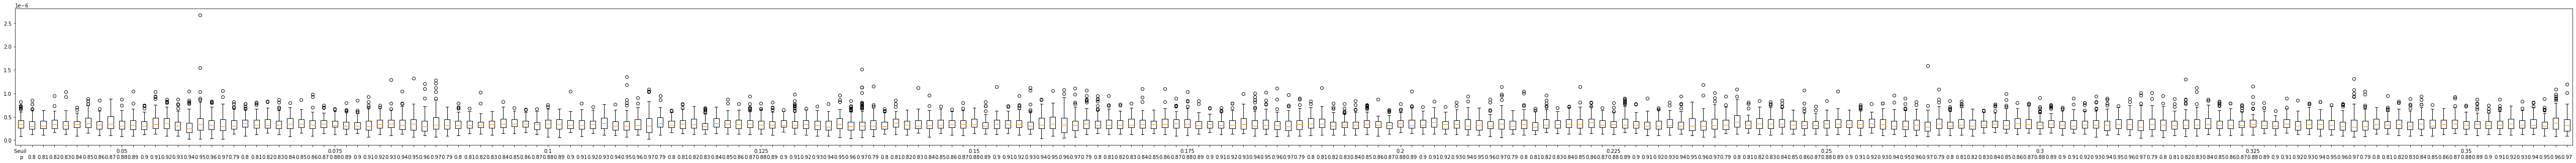

CPU times: user 3.66 s, sys: 55 ms, total: 3.71 s
Wall time: 3.71 s


In [42]:
%%time
n = 100
seuils = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3, 0.325, 0.35]
ps = [0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94,0.95, 0.96,0.97]
#Heatmap("probas4", seuils, ps, n, saut_1)
analyse("probas4.npy", seuils, ps)

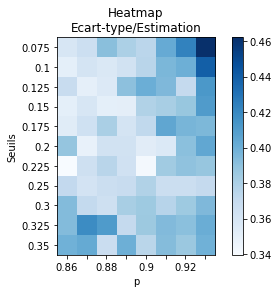

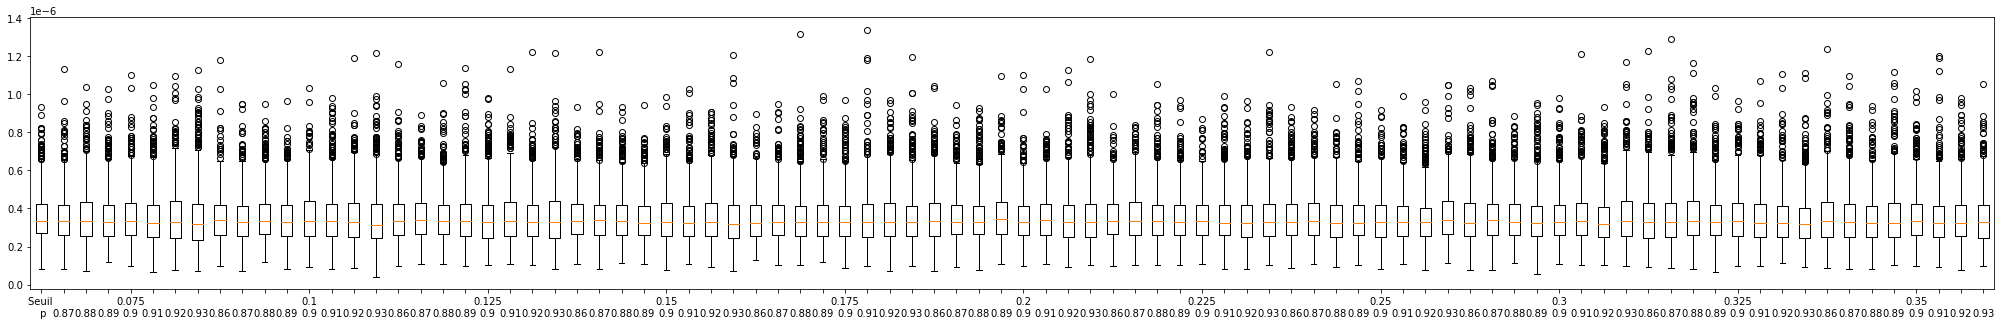

CPU times: user 1.5 s, sys: 23 ms, total: 1.53 s
Wall time: 1.53 s


In [43]:
%%time
n = 1000 
seuils = [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3, 0.325, 0.35]
ps = [0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93]
#Heatmap("probas5", seuils, ps, n, saut_1)
analyse("probas5.npy", seuils, ps)

/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


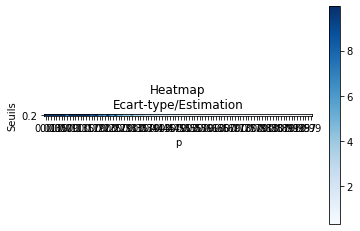

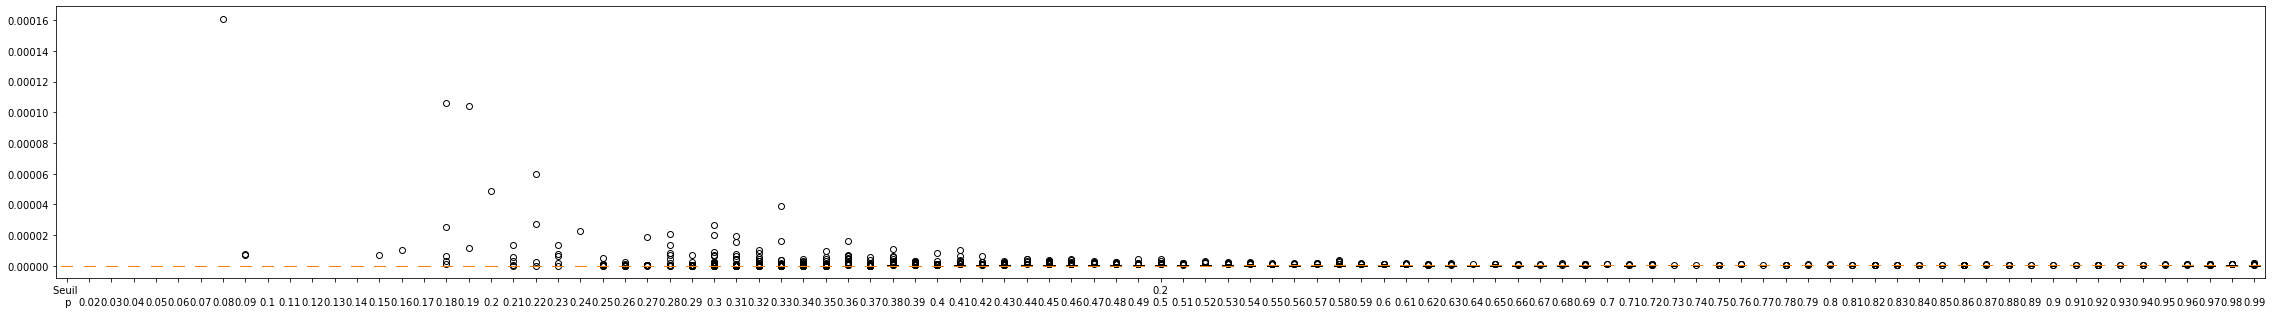

CPU times: user 2.03 s, sys: 27 ms, total: 2.06 s
Wall time: 2.06 s


In [44]:
%%time
# solo
n = 100
seuils = [0.2]
ps = [i / 100 for i in range(1, 100)]
#Heatmap("probas_solo", seuils, ps, n, saut_1)
analyse("probas_solo.npy", seuils, ps)

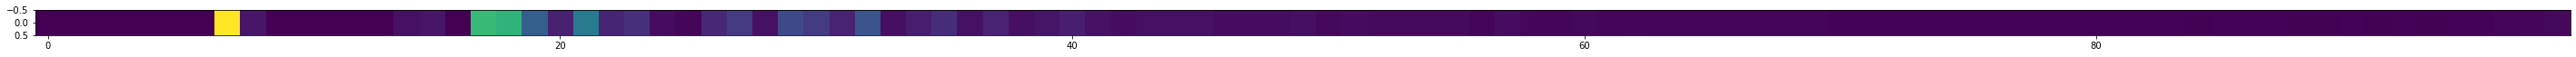

In [49]:
plt.figure(figsize=(50, 10))
plt.imshow(probas.std(axis=2))

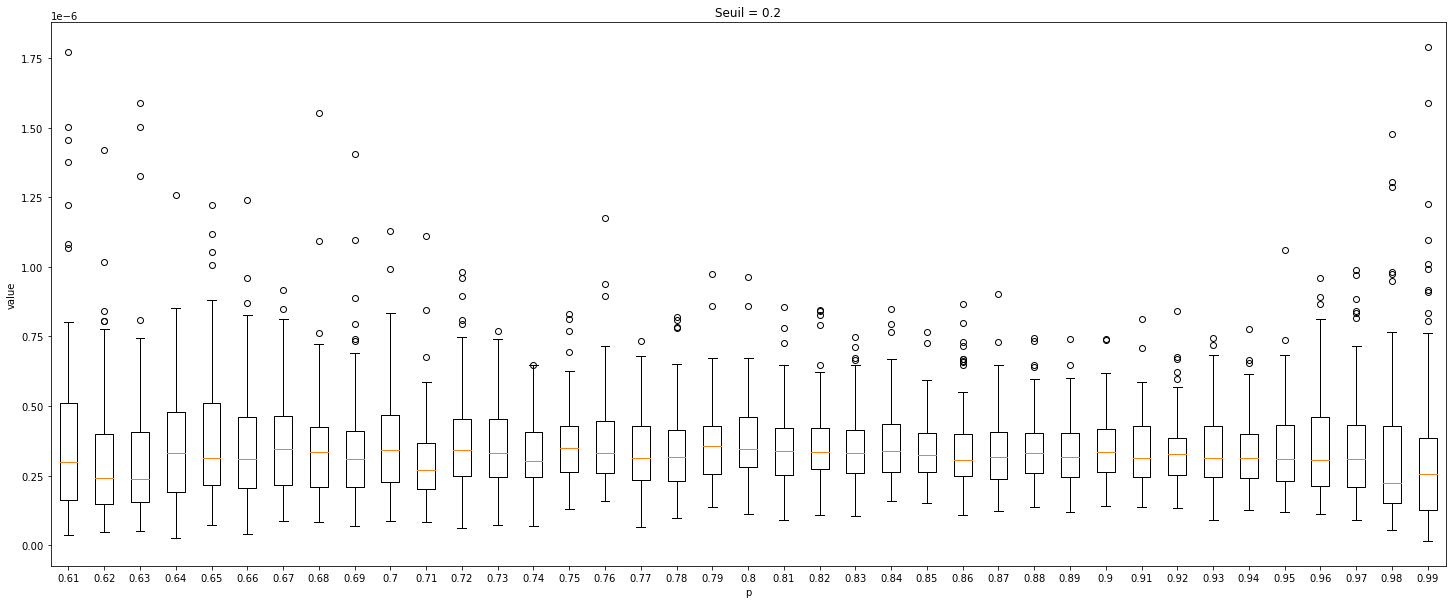

In [46]:
probas = np.load("probas_solo.npy")
plt.figure(figsize=(25, 10))
plt.boxplot([probas[i][j] for i in range(1) for j in range(60, 99)])
plt.xticks([i for i in range(1, 40)], [str((61 + i)/100) for i in range(39)])
plt.xlabel("p")
plt.ylabel("value")
plt.title("Seuil = 0.2")
plt.savefig("boxplot_solo.png")
plt.show()

In [38]:
np.load("probas_solo.npy").mean(axis=2)[0][50:]

array([3.06227957e-07, 3.79874076e-07, 3.42566714e-07, 3.66727104e-07,
       3.90180552e-07, 3.88387520e-07, 3.75559273e-07, 4.12565701e-07,
       3.86587512e-07, 3.61955861e-07, 3.90677807e-07, 3.11157124e-07,
       3.22817719e-07, 3.50967904e-07, 3.89464067e-07, 3.61748941e-07,
       3.71838550e-07, 3.53660880e-07, 3.52385571e-07, 3.76854606e-07,
       3.02815980e-07, 3.73434415e-07, 3.51069520e-07, 3.27086948e-07,
       3.62738688e-07, 3.71159996e-07, 3.36369549e-07, 3.39179871e-07,
       3.62889758e-07, 3.76306675e-07, 3.64241133e-07, 3.67581369e-07,
       3.52795055e-07, 3.62497443e-07, 3.44530545e-07, 3.44774434e-07,
       3.41907363e-07, 3.45966013e-07, 3.30983442e-07, 3.48565725e-07,
       3.47727414e-07, 3.41148127e-07, 3.43110160e-07, 3.28957954e-07,
       3.39030550e-07, 3.48781928e-07, 3.57589417e-07, 3.26348421e-07,
       3.37691136e-07])

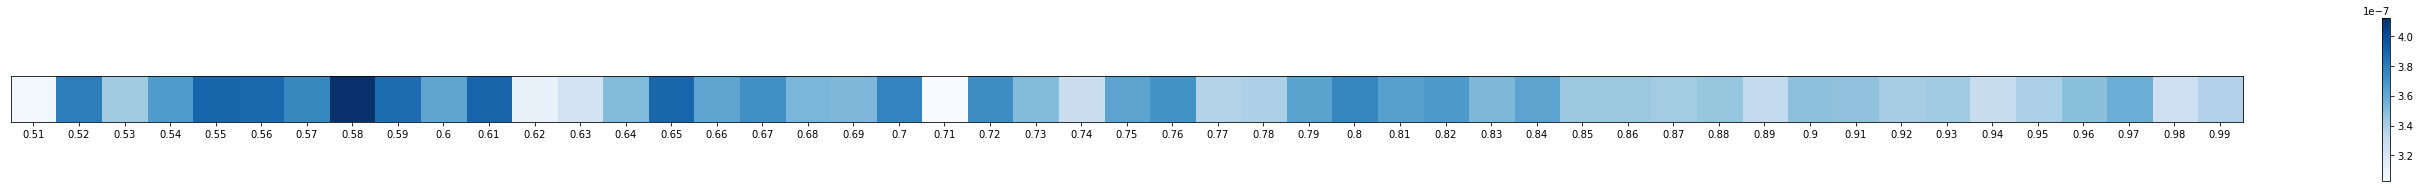

In [50]:
plt.figure(figsize=(50, 3))
plt.imshow([np.load("probas_solo.npy").mean(axis=2)[0][50:]], cmap=plt.cm.Blues)
plt.yticks([])
plt.xticks([i for i in range(99-50)], [i / 100 for i in range(51, 100)])
plt.colorbar()

In [52]:
%%time
P0 = 35
T = 4*60*60 #conversion en secondes
lamb =  1/300 
M1 = int(1e3)
M2 = int(1e7)
n = 1
a=0
#Choix des paramètres pour les niveaux de splitting et la simulation par chaîne de Markov
p = 0.9
seuil = 0.225
probas = Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut_1)
print(probas.mean())
print(probas.std())

[26. 21. 17. 14. 10.  7.  4.  1.  0.]



3.5241204416039264e-07
0.0
CPU times: user 6min 56s, sys: 14.6 ms, total: 6min 56s
Wall time: 6min 56s


### m = 3

Processing with seuil = 0.01, p = 0.1
[5. 0.]



Processing with seuil = 0.01, p = 0.3
[5. 0.]



Processing with seuil = 0.01, p = 0.5
[5. 0.]



Processing with seuil = 0.01, p = 0.7
[3. 0.]



Processing with seuil = 0.01, p = 0.9
[6. 0.]



Processing with seuil = 0.05, p = 0.1
[12.  0.]



Processing with seuil = 0.05, p = 0.3
[12.  0.]



Processing with seuil = 0.05, p = 0.5
[12.  0.]



Processing with seuil = 0.05, p = 0.7
[12.  0.]



Processing with seuil = 0.05, p = 0.9
[13.  0.]



Processing with seuil = 0.1, p = 0.1
[15.  3.  0.]



Processing with seuil = 0.1, p = 0.3
[15.  2.  0.]



Processing with seuil = 0.1, p = 0.5
[16.  2.  0.]



Processing with seuil = 0.1, p = 0.7
[15.  2.  0.]



Processing with seuil = 0.1, p = 0.9
[18.  5.  0.]



Processing with seuil = 0.15, p = 0.1
[18.  6.  0.]



Processing with seuil = 0.15, p = 0.3
[18.  8.  0.]



Processing with seuil = 0.15, p = 0.5
[19.  8.  0.]



Processing with seuil = 0.15, p = 0.7
[19.  7.  0.]



Processing with seuil = 0.15, p = 0.9
[18.  7.  0.]



Processing with seuil = 0.2, p = 0.1
[20.  6.  1.  0.]



Processing with seuil = 0.2, p = 0.3
[20. 10.  2.  0.]



Processing with seuil = 0.2, p = 0.5
[21. 11.  2.  0.]



Processing with seuil = 0.2, p = 0.7
[18.  7.  0.]



Processing with seuil = 0.2, p = 0.9
[22. 10.  3.  0.]



Processing with seuil = 0.25, p = 0.1
[21. 12.  4.  0.]



Processing with seuil = 0.25, p = 0.3
[21. 13.  7.  0.]



Processing with seuil = 0.25, p = 0.5
[22. 11.  4.  0.]



Processing with seuil = 0.25, p = 0.7
[21. 13.  5.  0.]



Processing with seuil = 0.25, p = 0.9
[24. 12.  4.  0.]



Processing with seuil = 0.3, p = 0.1
[22. 14.  8.  0.]



Processing with seuil = 0.3, p = 0.3
[23. 14.  7.  0.]



Processing with seuil = 0.3, p = 0.5
[23. 15.  8.  2.  0.]



Processing with seuil = 0.3, p = 0.7
[24. 15.  8.  2.  0.]



Processing with seuil = 0.3, p = 0.9
[23. 12.  5.  0.]



Processing with seuil = 0.35, p = 0.1
[25. 17. 10.  4.  1.  0.]



Processing with seuil = 0.35, p = 0.3
[24. 16.  9.  4.  1.  0.]



Processing with seuil = 0.35, p = 0.5
[24. 16.  9.  3.  0.]



Processing with seuil = 0.35, p = 0.7
[25. 17. 11.  5.  0.]



Processing with seuil = 0.35, p = 0.9
[25. 18. 11.  4.  0.]


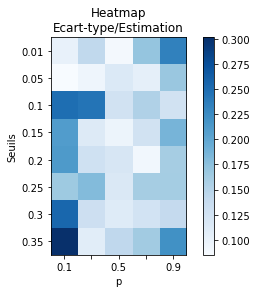

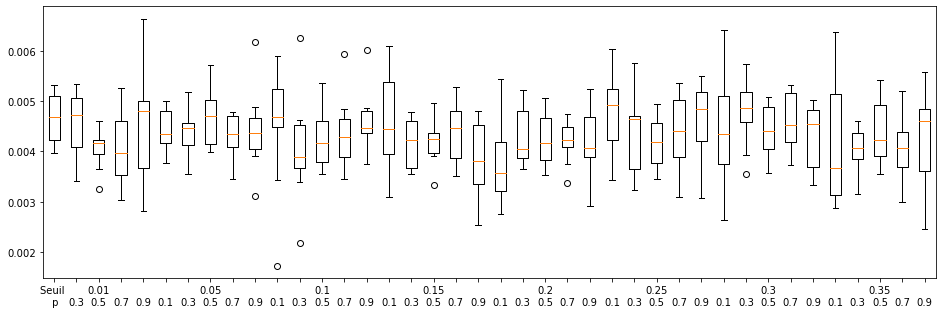

CPU times: user 4min 11s, sys: 178 ms, total: 4min 11s
Wall time: 4min 11s


In [57]:
%%time
P0 = 35 
T = 4*60*60 #conversion en secondes
lamb =  1/300 
M1 = int(1e3) 
M2 = 14400
n = 10
a=0

seuils = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
ps = [0.1, 0.3, 0.5, 0.7, 0.9]
Heatmap("probas1_m=3", seuils, ps, n, saut_2)
analyse("probas1_m=3.npy", seuils, ps)

In [87]:
%%time
P0 = 35
T = 4*60*60 #conversion en secondes
lamb =  1/300 
M1 = int(1e3)
M2 = int(1e7)
n = 10
a=0
#Choix des paramètres pour les niveaux de splitting et la simulation par chaîne de Markov
p = 0.7
seuil = 0.13
probas = Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut_2)
print(probas.mean())

[16.  5.  0.]



0.004324198316724137
CPU times: user 1h 11min 9s, sys: 162 ms, total: 1h 11min 9s
Wall time: 1h 11min 13s
